# Retrieval Augmented Generation (RAG): validación inicial y potencial








## Introducción

Este proyecto explora la aplicación de Retrieval Augmented Generation (RAG) para construir un sistema de consulta sobre documentos. En lugar de que el modelo de lenguaje responda únicamente con lo aprendido en su entrenamiento, se conecta a una base vectorial donde se almacenan fragmentos del texto. Frente a una pregunta, el sistema recupera los pasajes más relevantes y los aporta como contexto para que el modelo genere una respuesta fundamentada.

Como ejemplo de aplicación se utiliza el informe  [“Anthropic Education Report: How educators use Claude”](https://www.anthropic.com/news/anthropic-education-report-how-educators-use-claudeL) publicado por Anthropic en agosto de 2025.

La ténica RAG ofrece un gran potencial en entornos empresariales. Facilita la lectura de reportes internos y bases de conocimiento, habilita la creación de asistentes capaces de responder consultas de clientes o equipos y garantiza que las respuestas provengan de información verificada dentro de la organización.


##Implementación

### LangChain: Framework para integrar LLMs con RAG





El framework elegido para la construcción del sistema es LangChain, diseñado para integrar grandes modelos de lenguaje (LLMs) en desarrollos avanzados como chatbots, sistemas de recomendación o agentes inteligentes. Esta herramienta permite combinar el procesamiento de lenguaje natural con fuentes externas de información, ofreciendo componentes que simplifican la gestión de datos, las búsquedas eficientes y la organización de interacciones con LLMs. Resulta especialmente útil para implementar técnicas como RAG, ya que provee módulos específicos que aceleran y ordenan el proceso de desarrollo.

La técnica RAG requiere de al menos las siguientes tres etapas:

**1. Base de conocimiento (Knowledge base).** Construiremos una base de datos vectorial que permita indexar y almacenar los documentos a analizar, sus embeddings y metadatos. Esto incluye:
- a) Document Loaders: Leer documentos en distintos formatos (pdf, csv, word)
- b) Chunking con Text Splitters: dividir los documentos en fragmentos más pequeños
- c) Vectorizar: representar los chunks a través de embeddings, los cuales capturan la semántica y contexto de los textos. Para esto, usaremos un modelo codificador que reciba un texto y devuelva un vector denso de dimensión fija.
- d) Construir la base de datos vectorial: indexar y almacenar los chunks, embeddings y metadatos, facilitando la búsqueda y recuperación de chunks relevantes.

**2. Recuperación de información (Information retrieval).** A partir de una consulta, se recuperan los chunks más relevantes que contengan información útil para devolver una respuesta apropiada. Para ello:
- a) Vectorizar la pregunta: utilizando el mismo modelo codificador que la etapa anterior, de modo que la representación sea coherente con la utilizada para los chunks.
- b) Búsqueda semántica: utilizaremos un recuperador de información (retriever) que buscará en la base de datos vectorial los chunks más similares a la consulta. La comparación se realizará a nivel de embeddings utilizando la métrica de similitud coseno, devolviendo los chunks más relevantes ordenados por distancia.

**3. Generación aumentada (Augmented generation).** Crearemos un prompt utilizando los chunks recuperados y la consulta original. Este prompt será enviado al LLM para que genere una respuesta basada únicamente en el contexto proporcionado por los chunks, garantizando precisión y relevancia en la información devuelta.


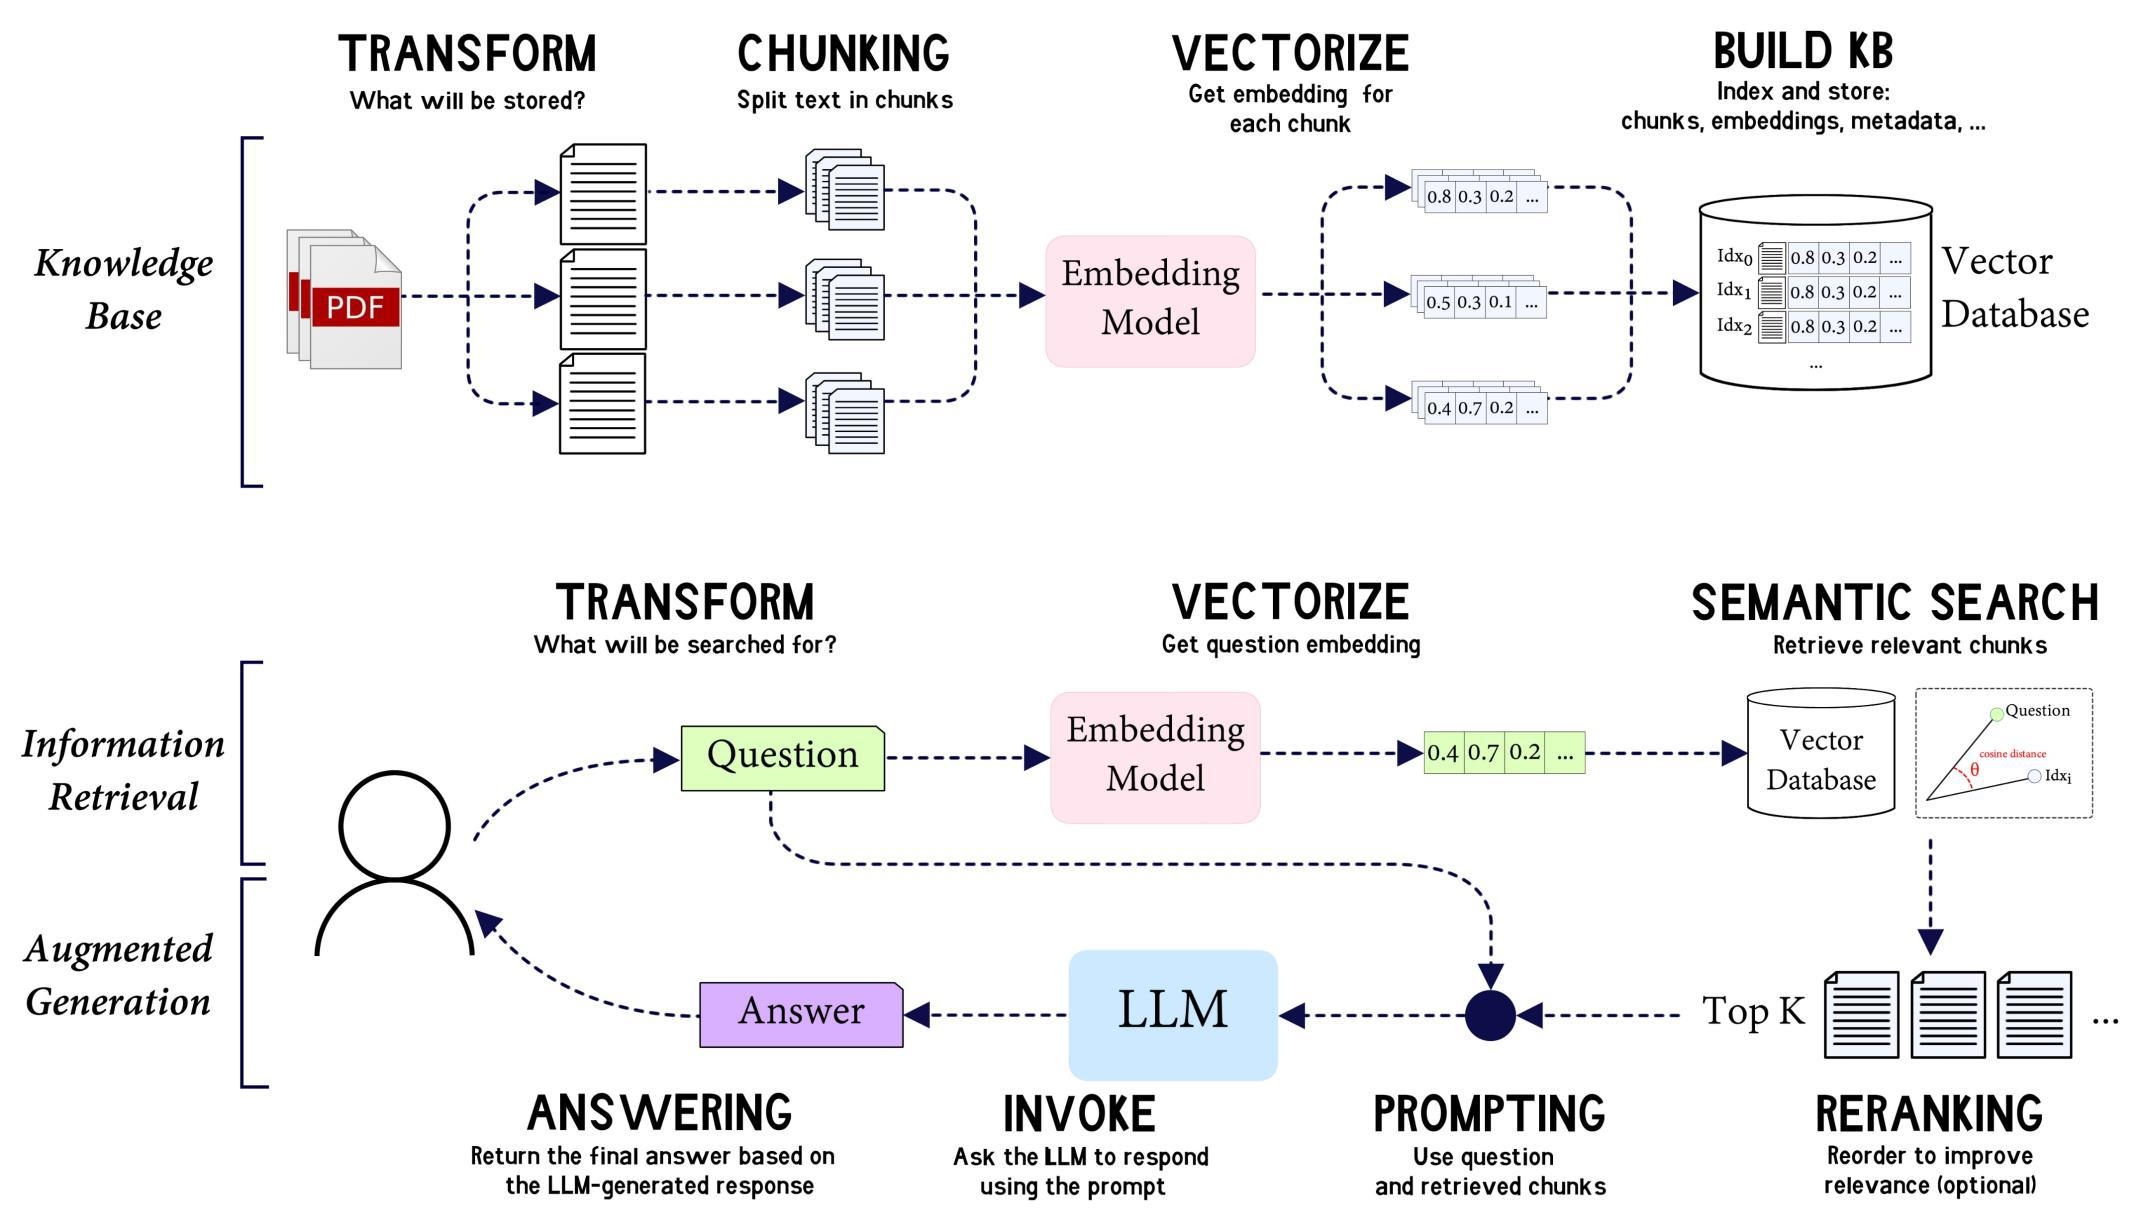

Comenzamos instalando algunos paquetes que no vienen preinstalados en Colaboratory

In [ ]:
%%capture
# Instalación de paquetes
!pip install langchain
!pip install -U langchain-community
!pip install -qU langchain-openai
!pip install openai
!pip install chromadb
!pip install python-dotenv
!pip install PyPDF

 Aunque lo recomendado es importar todas las librerías al inicio del código, en este trabajo se irán incorporando progresivamente a medida que se necesiten. Esto se debe a que el enfoque está diseñado para acompañar paso a paso el desarrollo del trabajo.

##Document Loaders

La primera etapa en la indexación de documentos con LangChain consiste en cargar los datos como "Documentos". Esta es una clase ubicada en el esquema del repositorio de LangChain, cuya función principal es representar fragmentos de texto. Para facilitar este proceso, se utilizan cargadores de documentos específicos según la fuente de los datos. En este caso, se emplearán cargadores para archivos PDF.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.document_loaders import PyPDFLoader

In [ ]:
# Ruta del directorio que contiene el/los documentos
ruta_directorio = "/content/drive/MyDrive/Proyecto RAG"

# Configurar el DirectoryLoader para procesar los PDFs
pdf_loader = DirectoryLoader(
    path=ruta_directorio,
    glob="*.pdf",  # Filtrar archivos con extensión .pdf
    loader_cls=PyPDFLoader  # Usar PyPDFLoader para cada PDF
)

# Cargar todos los documentos
documentos = pdf_loader.load()

# Revisar cuántos documentos se cargaron
print(f"Se cargaron {len(documentos)} documentos PDF.")

Se cargaron 9 documentos PDF.


Limpieza de documentos

In [ ]:
import re

# Normalizar espacios en el contenido de cada documento
for doc in documentos:
    doc.page_content = re.sub(r'\s+', ' ', doc.page_content).strip()

#Text Splitters

Los separadores de texto son herramientas esenciales cuando trabajamos con documentos extensos en aplicaciones de procesamiento de lenguaje natural. Estos separadores dividen textos largos en fragmentos más manejables, asegurándose de mantener la coherencia y el contexto. Esto es crucial porque los modelos de lenguaje suelen tener limitaciones en la cantidad de texto que pueden procesar de una vez. LangChain aborda este desafío con separadores de texto que permiten dividir, combinar y adaptar los documentos para optimizar su uso en diferentes aplicaciones. De esta manera, logramos fragmentos que no solo son más fáciles de procesar, sino que también conservan el significado general del texto.

Entre las opciones disponibles, el RecursiveCharacterTextSplitter destaca como la herramienta predeterminada en LangChain. Este separador es altamente efectivo porque prioriza preservar el contexto semántico mientras divide el texto de manera estratégica. No obstante, es posible personalizar su funcionamiento definiendo el tamaño máximo de cada fragmento (chunk_size) y la superposición entre fragmentos (chunk_overlap). Esto permite adaptarlo a las necesidades específicas de la tarea, asegurando un equilibrio óptimo entre el tamaño de los fragmentos y la continuidad del contexto.


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 200,
    length_function = len,
    #separators=["\n\n", "\n", ". ", " ", ""]
)

In [ ]:
split = text_splitter.split_documents(documentos)

#Modelos de embeddings

Los embeddings son representaciones vectoriales de palabras, frases o documentos que capturan su significado y las relaciones semánticas entre ellos, siendo fundamentales para aplicaciones como la búsqueda semántica y el análisis de texto en modelos de lenguaje natural. Estos modelos convierten el texto en vectores numéricos de tamaño fijo que permiten a los algoritmos trabajar en un espacio vectorial, donde conceptos similares están más próximos. LangChain, a través de su clase Embeddings, proporciona una interfaz estándar para interactuar con diversos modelos, como OpenAI, Cohere o Hugging Face, ofreciendo flexibilidad para vectorizar documentos y consultas.


#OpenAI embeddings

Para este trabajo, utilizaremos los modelos de embeddings de OpenAI, conocidos por su precisión y capacidad para capturar relaciones semánticas complejas. Es importante destacar que el acceso a los modelos de OpenAI requiere autenticarse mediante una API key, y su uso está asociado a un costo, ya que se trata de un servicio pago.

Para proteger la seguridad de nuestra API key al utilizar los modelos de embeddings de OpenAI, emplearemos un enfoque que evita exponer la clave directamente en el código. Utilizaremos el módulo getpass para solicitar la clave al usuario de manera interactiva, y luego la almacenaremos temporalmente en una variable de entorno utilizando el módulo os. Este método asegura que la clave no quede visible ni sea compartida accidentalmente.

In [ ]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Base de datos vectorial Chroma

Para vectorizar los documentos se utilizará Chroma, una herramienta eficiente y sencilla para el almacenamiento y consulta de datos vectoriales. Aunque es ideal para entornos de desarrollo y prototipado, existen otras opciones como Pinecone, Weaviate y FAISS, que también pueden usarse dependiendo del caso de uso.

En un entorno de producción, Pinecone sería más adecuada gracias a su escalabilidad, alto rendimiento y gestión en la nube. Además, garantiza alta disponibilidad y elimina la necesidad de configurar infraestructura propia, lo que la convierte en una opción robusta para manejar grandes volúmenes de datos.

Se importan las clases necesarias para trabajar con embeddings de OpenAI y almacenar vectores utilizando Chroma.

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

*Configuración del directorio de almacenamiento de la base vecotorial*.

Se define la ruta donde se guardarán de forma persistente los datos generados durante el procesamiento. Esto es particularmente importante para mantener los índices o bases vectoriales utilizados en el proyecto, de modo que puedan ser reutilizados sin necesidad de reconstruirlos en cada ejecución. Se utilizará Google Drive como espacio de almacenamiento para garantizar que los datos permanezcan accesibles y seguros.

In [ ]:
persist_directory = "/content/drive/My Drive/Proyecto RAG/ChromaStore"

*Creación y almacenamiento de la base vectorial*

En el siguiente paso, se verifica si la base vectorial ya existe en la ubicación definida por persist_directory. Si existe, se carga la base vectorial utilizando Chroma y los embeddings generados con OpenAIEmbeddings. Si no existe, se crea una nueva base vectorial a partir de los documentos procesados previamente (split) y los embeddings generados, utilizando también Chroma. Una vez creada, la base se guarda en la ubicación especificada mediante el método persist() para garantizar que los datos sean almacenados de forma permanente y puedan ser reutilizados en futuras ejecuciones. En este caso, persist_directory está configurado en Google Drive.

In [ ]:
from pathlib import Path

# Verificar si el vectorstore ya existe
if Path(persist_directory).exists():
    # Cargar el vectorstore existente
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=OpenAIEmbeddings()
    )
    print(f"Vectorstore cargado correctamente desde {persist_directory}.")
else:
    vectorstore = Chroma.from_documents(
        documents=split,
        embedding=OpenAIEmbeddings(),
        persist_directory=persist_directory
    )
    # Persistir los datos
    vectorstore.persist()
    print(f"Vectorstore guardado correctamente en {persist_directory}.")

Vectorstore cargado correctamente desde /content/drive/My Drive/Proyecto RAG/ChromaStore.


In [ ]:
# Ver el formato de vectorstore
vectorstore.get().keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'included', 'data', 'metadatas'])

In [ ]:
# Ver el contenido (por defecto devuelve ids, metadatas, documents)
vectorstore.get()

Incluso podemos ver los los indices, documentos y embeddings

In [ ]:
# Indicamos los elementos a obtener obtener
db_documentos = vectorstore.get(include=['documents', 'embeddings'])
# Número de elementos a mostrar
N = 5
# Extraer las listas de cada clave
ids = db_documentos['ids']
docs = db_documentos['documents']
embs = db_documentos['embeddings']

# Zipear las listas y mostrar los primeros N elementos
for i, (id_, d, e) in enumerate(zip(ids, docs, embs)):
    if i >= N:
        break
    print(f"ID: {id_}\nDocumento: {d}\nEmbedding: {e}\n")

ID: aad70a50-8813-45dc-b4b3-4b7b6b321596
Documento: Anthropic Education Report: How educators use Claude 26 ago 2025 Fuente: https://www.anthropic.com/news/anthropic-education-report-how- educators-use-claude Understandably, much of the conversation of AI in education focuses on how students are using large language models to help them study and write. But educators use AI too. In a recent Gallup survey, teachers reported that AI tools saved them an average of 5.9 hours per week. And in an inversion of the usual discussion, students have begun expressing concerns about professors using AI in the classroom. We previously reported data on how students were using AI. Our new analysis looks at professors: we analyzed ~74,000 anonymized conversations from higher education professionals across the world on Claude.ai this past May and June.1 We also partnered with Northeastern University to hear directly from faculty how they were using AI within the university. Our findings provide an empiri

# Recuperación de información

La función vectorstore.as_retriever() nos permite configurar una interfaz para la base de datos vectorial, que utilizaremos para realizar búsquedas semánticas y recuperar los documentos más relevantes a una consulta.

Por defecto, utiliza un método de búsqueda basado en similitud (search_type="similarity") y recupera los 4 documentos más relevantes (search_kwargs={"k": 4}). Estos parámetros son personalizables.

In [ ]:
retriever = vectorstore.as_retriever()

# Generación aumentada


Diseñaremos un sistema de preguntas y respuestas (QA) utilizando OpenAI.

Para este proyecto, usaremos nuestra API Key para acceder a los modelos disponibles y configuraremos el modelo para que sea mayormente determinístico. Los principales parámetros que ajustaremos son los siguientes:

Modelo (model_name): Hemos seleccionado gpt-4o-mini por su balance entre eficiencia y capacidad para generar respuestas precisas.

Temperatura (temperature): Controla el grado de creatividad en las respuestas, con valores entre 0 y 1. Un valor cercano a 1 permite respuestas más creativas, mientras que un valor cercano a 0 genera respuestas más conservadoras y alineadas con los datos disponibles. En este caso, configuramos la temperatura en 0 para asegurar que las respuestas se ajusten estrictamente a la información proporcionada.

Tokens máximos (max_tokens): Define la longitud máxima de las respuestas. Hemos establecido un límite de 500 tokens para garantizar respuestas concisas y manejables.


In [ ]:
from langchain.chat_models import ChatOpenAI

In [ ]:
llm = ChatOpenAI(
    model_name = 'gpt-4o-mini',
    temperature = 0,
    max_tokens = 500
)

# ver y comparar costos de modelos en https://platform.openai.com/docs/pricing

Construimos el Prompt, que es una serie de instrucciones que le daremos al LLM para resolver la tarea.

Indicaremos al LLM que debe responder consultas, considerando específicamente el contexto formado por los documentos más relaciodados con la consulta.

Esta implementación de la técnica de RAG permite adaptar al modelo para generar respuestas fundamentadas y basadas en información relevante, mejorando así la calidad y precisión de las respuestas obtenidas.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
template = ("Eres un asistente para tareas de question-answering. Usa el siguiente contexto para responder la solictud."
          "Debes responder únicamente con información de la base vectorial."
          "Pregunta {question}\n"
          "Contexto: {context}\n"
          "Respuesta:")

# Definir el prompt como un template de chat
prompt = ChatPromptTemplate.from_template(template)
prompt



ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Eres un asistente para tareas de question-answering. Usa el siguiente contexto para responder la solictud.Debes responder únicamente con información de la base vectorial.Pregunta {question}\nContexto: {context}\nRespuesta:'), additional_kwargs={})])

In [ ]:
from langchain_core.runnables import RunnablePassthrough # Pasar contenido sin modificar (para Pipelines)
from langchain_core.output_parsers import StrOutputParser
from IPython.display import Markdown

Diseñamos un pipeline, una secuencia estructurada de operaciones en la que el resultado de cada etapa se utiliza como entrada para la siguiente. El flujo funciona de la siguiente manera:

1) Generación del contexto: Se utiliza un retriever para recuperar los documentos más relevantes, que luego pasan por format_docs para unificar el contenido en un único texto coherente.

2) Procesamiento de la pregunta: El contenido de la consulta (question) se transfiere sin modificaciones mediante RunnablePassthrough.

3) Creación del diccionario: Se construye un diccionario que contiene el contexto generado y la pregunta (context y question).

4) Generación del prompt: Este diccionario alimenta el prompt, que estructura las instrucciones para el modelo.

5) Procesamiento en el LLM: El prompt se envía al modelo de lenguaje (LLM), donde se ejecuta la lógica de RAG (Retrieval-Augmented Generation).

6) Parámetro de salida: La respuesta generada por el LLM pasa a través de
StrOutputParser, que la transforma en un formato estándar para su presentación final.

Esta configuración asegura que el flujo sea lógico, eficiente y fácil de interpretar en cada etapa del proceso.

In [ ]:
def format_docs(docs):
    # Funcion auxiliar para enviar el contexto al modelo como parte del prompt
    return "\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

Saludamos y el modelo nos saluda y nos ofrece ayuda.

In [ ]:
# Preguntas a la Base de Conocimiento
pregunta = "¿Cómo está cambiando la forma de enseñar por la aparición de la IA?" # @param {type:"string"}
response = rag_chain.invoke(pregunta)

print("Respuesta del modelo:")

for chunk in rag_chain.stream(pregunta): # streaming
    print(chunk, end="", flush=True)


Respuesta del modelo:
La aparición de la IA está cambiando la forma de enseñar al presionar a los educadores a modificar sus métodos de enseñanza. Los profesores están dedicando mucho esfuerzo a abordar el problema de la "carga cognitiva" y están cambiando el contenido que enseñan. Por ejemplo, en la enseñanza de programación, la IA ha revolucionado la experiencia de aprendizaje al permitir que los educadores se concentren en conceptos en lugar de en detalles técnicos menores. Además, la capacidad de evaluar la precisión del contenido generado por IA se está volviendo crucial, ya que la cantidad de generación de IA aumenta, lo que puede resultar abrumador para los humanos.

Los educadores también están utilizando herramientas de IA para ahorrar tiempo en tareas administrativas, lo que les permite dedicar más tiempo a la enseñanza. Sin embargo, hay preocupaciones entre los estudiantes sobre el uso de IA por parte de los profesores en el aula. La adopción de IA por parte de los educadore

In [ ]:
# Preguntas a la Base de Conocimiento
pregunta = "¿Cuáles son los usos más comunes de la IA entre los docentes universitarios?" # @param {type:"string"}
response = rag_chain.invoke(pregunta)

for chunk in rag_chain.stream(pregunta):
    print(chunk, end="", flush=True)

Los usos más comunes de la IA entre los docentes universitarios incluyen:

1. **Desarrollo de currículo**: La creación de materiales de curso es la aplicación más prominente de la IA.
2. **Investigación académica**: Los educadores utilizan IA para apoyar sus investigaciones.
3. **Evaluación del rendimiento estudiantil**: La IA se emplea para evaluar el desempeño de los estudiantes.
4. **Creación de simulaciones educativas**: Por ejemplo, escenarios legales simulados para la enseñanza.
5. **Desarrollo de contenido para educación vocacional y capacitación laboral**.
6. **Redacción de cartas de recomendación**: Para aplicaciones académicas o profesionales.
7. **Creación de agendas de reuniones y documentos administrativos relacionados**.
8. **Automatización de tareas tediosas**: Los docentes utilizan IA para manejar tareas repetitivas y administrativas.
9. **Asociación de pensamiento colaborativo**: La IA ayuda a encontrar formas efectivas de explicar conceptos a los estudiantes.
10. **Ex

Ahora si comenzamos a hacer las preguntas a la base de conocimiento y la respuesta del modelo se ajusta a lo esperado.

In [ ]:
# Preguntas a la Base de Conocimiento
pregunta = "¿En qué tareas prefieren colaborar con la IA y en cuáles automatizan más?"  # @param {type:"string"}

print("Respuesta del modelo:")

for chunk in rag_chain.stream(pregunta):
    print(chunk, end="", flush=True)


Respuesta del modelo:
Los educadores prefieren colaborar con la IA en tareas que requieren contexto significativo, creatividad o interacción directa con los estudiantes. Estas tareas incluyen:

- Diseño de lecciones (77.4% de uso colaborativo).
- Redacción de propuestas de subvención (70.0% de uso colaborativo).
- Asesoramiento académico y mentoría de organizaciones estudiantiles (67.5% de uso colaborativo).
- Supervisión del trabajo académico de los estudiantes (66.9% de uso colaborativo).

Por otro lado, las tareas que tienden a ser más automatizadas son:

- Gestión de las finanzas de la institución educativa y recaudación de fondos (65.0% de automatización).
- Mantenimiento de registros estudiantiles y evaluación del rendimiento académico (48.9% de automatización).
- Gestión de admisiones y matrícula académica (44.7% de automatización). 

Esto indica que las tareas administrativas rutinarias son más propensas a ser delegadas completamente a la IA, mientras que las que implican inter

# Conclusiones

Este proyecto constituye un primer paso en el desarrollo de un prototipo de sistema de recuperación aumentada por generación (RAG), orientado a responder consultas con rapidez y precisión a partir de documentos propios. Con esta primera versión se validó la funcionalidad básica de la técnica, demostrando que es posible integrar conocimiento contextualizado y generar respuestas relevantes.

Un aspecto interesante observado en la demo es que, aunque el documento base está en inglés, el sistema permite realizar consultas en español. El modelo traduce implícitamente la pregunta, recupera la información relevante y genera la respuesta en el idioma de la consulta, lo que amplía su alcance y usabilidad.

RAG abre la puerta a múltiples aplicaciones, desde el análisis de información corporativa y académica, hasta el soporte en procesos de toma de decisiones, atención a clientes, capacitación interna o investigación. Su capacidad de combinar recuperación de datos con generación de lenguaje natural la convierte en una herramienta versátil, con posibilidades de adaptación a entornos empresariales, educativos y de investigación.


## Aprendizajes y créditos

La idea de este proyecto surgió en la materia **Minería de Textos** de la *Especialización en Inteligencia de Datos orientada a Big Data*, dictada en la **Facultad de Informática de la UNLP** por el profesor **Marcelo Errecalde**.  

Durante esa cursada conocí en profundidad los **Transformers**, una arquitectura que me deslumbró y que abrió la puerta a explorar aplicaciones prácticas como este prototipo de RAG. Marcelo es un gran docente, y sus clases fueron clave para despertar mi interés en este campo.


Lic. Verónica Teilletchea

veronica.teilletchea@gmail.com